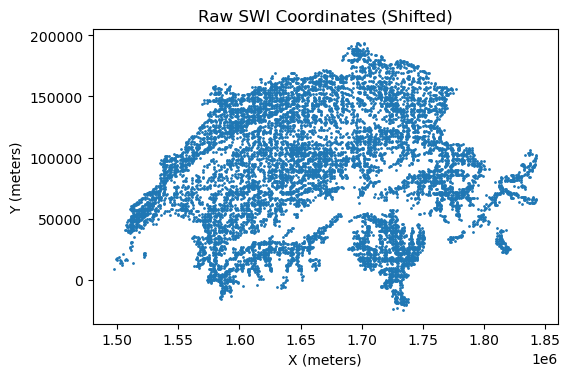

In [46]:
from pyproj import Transformer
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


np.set_printoptions(threshold=np.inf)      # print entire array, no truncation
np.set_printoptions(linewidth=np.inf) 

env=pd.read_csv("data_SDM_NCEAS/SWItest_env.csv")
#lats, lons = coord_trans(env["x"].values, env["y"].values)





plt.figure(figsize=(6, 10))
plt.scatter(env["x"], env["y"], s=1)
plt.gca().set_aspect('equal', 'box')
plt.title("Raw SWI Coordinates (Shifted)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()

shifted minimum x: 1497037.5
shifted minimum y: -25062.5
actual minimum x: 485410.0090516365
actual minimum y: 75263.6477937577
1011627.4909483634 -100326.1477937577


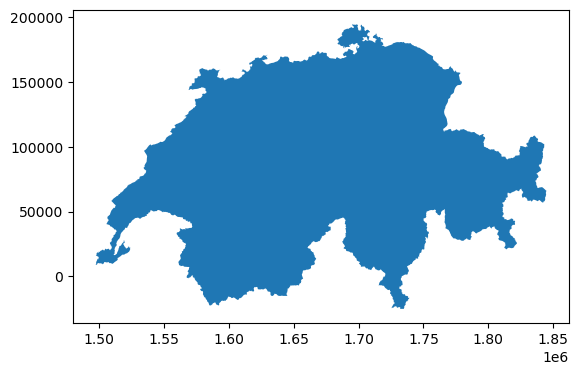

In [47]:
borders=gpd.read_file("data_SDM_NCEAS/Borders/swi.gpkg")
minx, miny, maxx, maxy = borders.total_bounds

print("shifted minimum x:", minx)
print("shifted minimum y:", miny)
borders.plot()

#46.132366, 5.955899    Minimizing west point
#45.817921, 9.017064    Minimizing south point

from pyproj import Transformer

def coord_trans(x, y, order="CH_to_normal"):

    if order == "CH_to_normal":
        transformer = Transformer.from_crs("EPSG:21781", "EPSG:4326", always_xy=True)
        x_out, y_out = transformer.transform(x, y)  # X=Easting, Y=Northing
    elif order == "normal_to_CH":
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781", always_xy=True)
        x_out, y_out = transformer.transform(x, y)  # X=Longitude, Y=Latitude
    else:
        raise ValueError("order must be either 'CH_to_normal' or 'normal_to_CH'")
    return x_out, y_out


We_min=coord_trans(5.955899 ,46.132366 , order="normal_to_CH") #coords from google maps: First longitude! always x,y
So_min=coord_trans(9.017064, 45.817921,order="normal_to_CH")
print("actual minimum x:", We_min[0])
print("actual minimum y:", So_min[1])
shift_x=minx-We_min[0]
shift_y=miny-So_min[1]
print(shift_x, shift_y)



In [58]:
#Test:

lons, lats = coord_trans(env["x"].values-shift_x, env["y"].values-shift_y,order="CH_to_normal")

print(lons.shape)
lons, lats

idx_east = np.argmin(lons)   # index of the maximum longitude
lat_east = lats[idx_east]
lon_east = lons[idx_east]

print(lat_east, lon_east) #eastern point fall 200m beyond the border...

idx_east = np.argmax(lats)   # index of the maximum longitude
lat_east = lats[idx_east]
lon_east = lons[idx_east]

print(lat_east, lon_east) #eastern point fall 200m beyond the border...

(10013,)
46.12521834952867 5.956255309022179
47.79357289591076 8.565322361150569


/tmp/ipykernel_1229328/3177588617.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = borders.boundary.unary_union  # Merge all boundaries


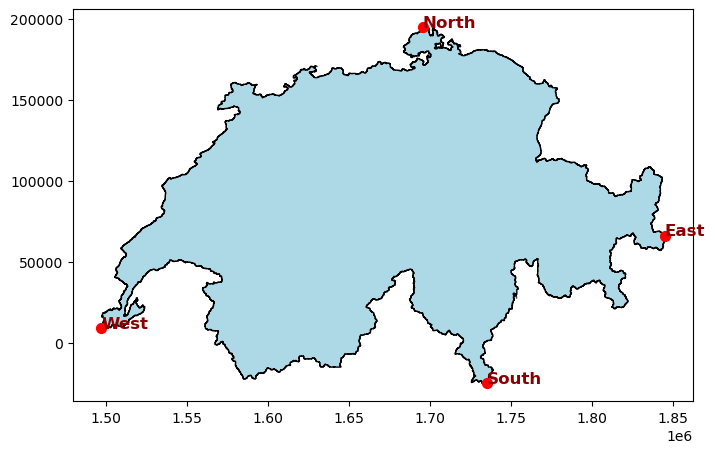

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load Switzerland borders
borders = gpd.read_file("data_SDM_NCEAS/Borders/swi.gpkg")

# Get the boundary as a LineString (or MultiLineString)
boundary = borders.boundary.unary_union  # Merge all boundaries

# Extract extremal points
minx_point = maxx_point = miny_point = maxy_point = None
minx_val = float('inf')
maxx_val = -float('inf')
miny_val = float('inf')
maxy_val = -float('inf')

# Iterate over all points in the boundary
for geom in boundary.geoms if hasattr(boundary, 'geoms') else [boundary]:
    for x, y in geom.coords:
        if x < minx_val:
            minx_val = x
            minx_point = Point(x, y)
        if x > maxx_val:
            maxx_val = x
            maxx_point = Point(x, y)
        if y < miny_val:
            miny_val = y
            miny_point = Point(x, y)
        if y > maxy_val:
            maxy_val = y
            maxy_point = Point(x, y)

# Combine into GeoDataFrame
extremal_points = gpd.GeoDataFrame(
    geometry=[minx_point, maxx_point, miny_point, maxy_point],
    crs=borders.crs
)

# Plot
ax = borders.plot(color='lightblue', edgecolor='black', figsize=(8,6))
extremal_points.plot(ax=ax, color='red', markersize=50)

# Optional: label the points
labels = ['West', 'East', 'South', 'North']
for point, label in zip(extremal_points.geometry, labels):
    plt.text(point.x, point.y, label, fontsize=12, fontweight='bold', color='darkred')

plt.show()


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


<Axes: >

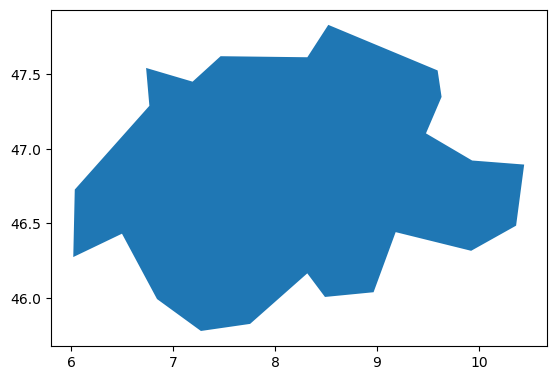

In [52]:
#inal test: plot on map:

boundaries = gpd.read_file("data_SDM_NCEAS/borders_natural_earth/ne_110m_admin_0_countries.shp")
#boundaries.plot() 
print(boundaries.columns) 
switzerland = boundaries[boundaries['NAME'] == 'Switzerland'] 
switzerland.plot()

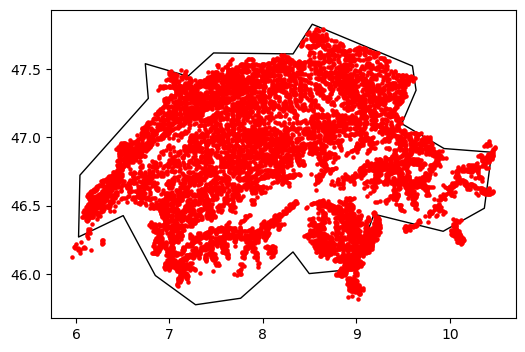

In [53]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Switzerland polygon
switzerland = boundaries[boundaries['NAME'] == 'Switzerland']

# Create GeoDataFrame of points
x = lons
y = lats

points = gpd.GeoDataFrame(
    geometry=[Point(xy) for xy in zip(x, y)],
    crs=switzerland.crs                # make sure both layers use same CRS
)

# Plot polygon + points on same axes
fig, ax = plt.subplots(figsize=(6,6))
switzerland.plot(ax=ax, color="white", edgecolor="black")
points.plot(ax=ax, color="red", markersize=5)

plt.show()


In [ ]:
'''import folium

m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=4)

# Add points
for lat, lon in zip(lats, lons):
    folium.CircleMarker(location=[lat, lon], radius=3).add_to(m)

m.save("folium_map.html")'''